### Code for experiments in term paper CHEMENG 468
based on the example: https://github.com/normal-computing/thermox/blob/main/examples/thermodynamic_linear_algebra.ipynb

December 2024, Nik Leuenberger

In [1]:
## configuration
# Python        3.10.15
# thermox       0.0.3
# jax           0.4.34                   
# jaxlib        0.4.34               
# fmmax         0.10.1  
# matplotlib    3.9.2
# numpy         1.26.4

In [2]:
import thermox
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve, inv, expm
import matplotlib.pyplot as plt
import numpy as np

#### Setup the problem

In [3]:
x_low = 0
x_high = 1
n_x = 50
n_t = 10
dx = (x_high-x_low)/(n_x+1)
dt = 0.001
D = 1
lamda = D*dt/dx**2
t = np.linspace(0,n_t*dt,n_t+1)
def f(x):
    result = jnp.zeros_like(x)
    for i in range(0,len(x)):
        result = result.at[i].set((x[i]>0.4 and x[i] <0.6))
    return result

def get_a_n(n,L):
    return 2/n/np.pi*(np.cos(n*np.pi*0.4)-np.cos(n*np.pi*0.6))

def u_analytical(x,t,D):
    u = np.zeros((len(t),len(x)))
    for n in range(1,10000):#choose large number to converge sum
        u = u + get_a_n(n,1) * np.outer(np.exp(-D*(n*np.pi)**2*t),np.sin(n*np.pi*x))
    return u

#### conpute initial condition and analytical solution

In [4]:
x = jnp.linspace(x_low,x_high,n_x)
u0 = f(x)
x_analytcial = np.linspace(0,x_high,1000)
u = u_analytical(x_analytcial,t,D)


#### construct matrix

In [5]:
A = jax.scipy.linalg.toeplitz(jnp.concatenate((jnp.array([1+2*lamda,-lamda]),jnp.zeros((n_x-2)))))

#### get time integration bounds for averaging in equilibrium

In [6]:
def get_integration_bounds(A,b,relative_tolerance):
    epsilon_mu_0 = 1e-3 # chosen by the author without a particular reason
    epsilon_sigma_0 = 1e-3 # chosen by the author without a particular reason
    kappa_A = jax.numpy.linalg.cond(A)
    norm_A = jax.numpy.linalg.norm(A)
    norm_b = jax.numpy.linalg.norm(b)
    tau_r = 1.0/norm_A 
    kBT = 0.001 # chosen by the author without a particular reason
    beta = 1.0/kBT
    epsilon_x = relative_tolerance
    t0_hat = max(kappa_A*tau_r*jax.numpy.log(kappa_A/epsilon_mu_0), 0.5*kappa_A*tau_r*jax.numpy.log(2*kappa_A/epsilon_sigma_0))
    prob_epsilon = 0.99 # chosen by the author without a particular reason
    tau_hat = 2*kappa_A**2*n_x*norm_A/beta/norm_b**2/epsilon_x**2/(1-prob_epsilon)*tau_r
    return [t0_hat,tau_hat]

##### Time loop

In [7]:
def solve_diffusion(n_t,n_x,u0,tolerance):
    u_thermo = jnp.zeros((n_t+1,n_x))
    u_thermo = u_thermo.at[0,:].set(u0)
    for n in range(1,n_t+1):
        print("Timestep: %d", n)
        # construct the rhs
        b_thermo = u_thermo[n-1,:]
        # get integration bounds for desired tolerance
        [t0_hat,tau_hat] = get_integration_bounds(A,b_thermo,tolerance)
        # solve the linear system
        u_thermo = u_thermo.at[n,:].set(thermox.linalg.solve(A,b_thermo,int(tau_hat+t0_hat),burnin=int(t0_hat)))
        # check that relative tolerance is correct
        err_thermo = jax.numpy.linalg.norm(jax.numpy.matmul(A,u_thermo[n,:])- b_thermo)/jax.numpy.linalg.norm(b_thermo)
        # print the relative error
        print(err_thermo)
    return u_thermo

We will run two experiments: 
- the first where we solve the linear system with a relative tolerance of 0.01 at each timestep.
- the second where we solve the linear system with a relative tolerance of 0.1 at each timestep.

In [8]:
# Experiment 1 (approximate runtime 6 min)
u_exp1 = solve_diffusion(n_t,n_x,u0,1e-2)

Timestep: %d 1
0.00365493
Timestep: %d 2
0.003068045
Timestep: %d 3
0.0026029053
Timestep: %d 4
0.0036561189
Timestep: %d 5
0.0027658702
Timestep: %d 6
0.0030535918
Timestep: %d 7
0.0037090962
Timestep: %d 8
0.0021737267
Timestep: %d 9
0.0032338006
Timestep: %d 10
0.0030973267


In [9]:
# Experiment 2 (approximate runtime 3 min)
u_exp2 = solve_diffusion(n_t,n_x,u0,1e-1)

Timestep: %d 1
0.03697907
Timestep: %d 2
0.03187463
Timestep: %d 3
0.037620258
Timestep: %d 4
0.0355158
Timestep: %d 5
0.028970988
Timestep: %d 6
0.030589556
Timestep: %d 7
0.030527284
Timestep: %d 8
0.037293952
Timestep: %d 9
0.033594623
Timestep: %d 10
0.039436586


#### plot results

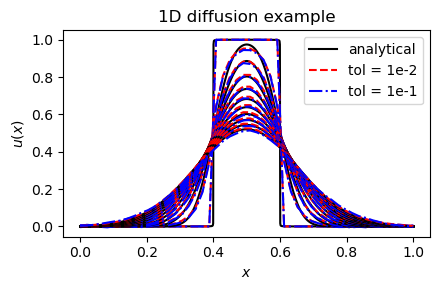

In [10]:
plt.figure(figsize=(3*1.5,2*1.5))
for i in range(0,len(t)):
    if i == 0:
        plt.plot(x_analytcial,u[i,:],'k',label = "analytical")
        plt.plot(x,u_exp1[i,:],'r--',label = "tol = 1e-2")
        plt.plot(x,u_exp2[i,:],'b-.', label = "tol = 1e-1")
    else:
        plt.plot(x_analytcial,u[i,:],'k')
        plt.plot(x,u_exp1[i,:],'r--')
        plt.plot(x,u_exp2[i,:],'b-.')
    plt.xlabel("$x$")
    plt.ylabel("$u(x)$")
plt.legend()
plt.title("1D diffusion example")
plt.tight_layout()
plt.savefig("diffusionbydiffusion.pdf")